## Setup

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.5
  [074ae576] CarloAnalysis v1.0.0-DEV `https://github.com/PatXue/CarloAnalysis.jl#main`
  [a93c6f00] DataFrames v1.8.0
  [e9467ef8] GLMakie v0.13.6
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [3]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using GLMakie
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [4]:
function generate_spins(jobname, task_no)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

## AFM-FE Phase Border

In [5]:
border_results = JobResult("../jobs", "afm-fe")

JobResult("../jobs", "afm-fe", 17×23 DataFrame
 Row │ ηz                T        savefreq  _ll_sweep_time    ηxy              ⋯
     │ Measurem…         Float64  Int64     Measurem…         Measurem…        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.00053±0.0001     0.01       2000  0.000439±1.6e-5   0.999903±1.1e-6  ⋯
   2 │  0.00023±0.00018    0.025      2000  0.000445±1.9e-5   0.999786±2.5e-6
   3 │  0.00028±0.00028    0.05       2000  0.000434±1.2e-5   0.41±0.11
   4 │ -0.00023±0.00024    0.075      2000  0.0004348±8.5e-6  0.05994±0.00081
   5 │ -0.0002±0.00029     0.1        2000  0.0004314±9.4e-6  0.241±0.089      ⋯
   6 │ -0.00028±0.00019    0.125      2000  0.0004382±7.5e-6  0.08±0.019
   7 │  0.00018±0.00037    0.15       2000  0.000473±2.3e-5   0.06022±0.00087
   8 │  0.00011±0.00037    0.175      2000  0.0004338±8.7e-6  0.06004±0.00059
  ⋮  │        ⋮             ⋮        ⋮             ⋮                 ⋮         ⋱
  11 │  3.

In [6]:
border_results[[:_ll_sweep_time, :_ll_measure_time]]

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.000439±1.6e-5,0.000123±3.7e-5
2,0.000445±1.9e-5,4.52e-5±1.5e-6
3,0.000434±1.2e-5,4.247e-5±6.1e-7
4,0.0004348±8.5e-6,4.207e-5±1.7e-7
5,0.0004314±9.4e-6,4.183e-5±1.8e-7
6,0.0004382±7.5e-6,4.304e-5±4.3e-7
7,0.000473±2.3e-5,4.71e-5±2.8e-6
8,0.0004338±8.7e-6,4.286e-5±2.7e-7
9,0.0004329±9.0e-6,4.277e-5±5.0e-7


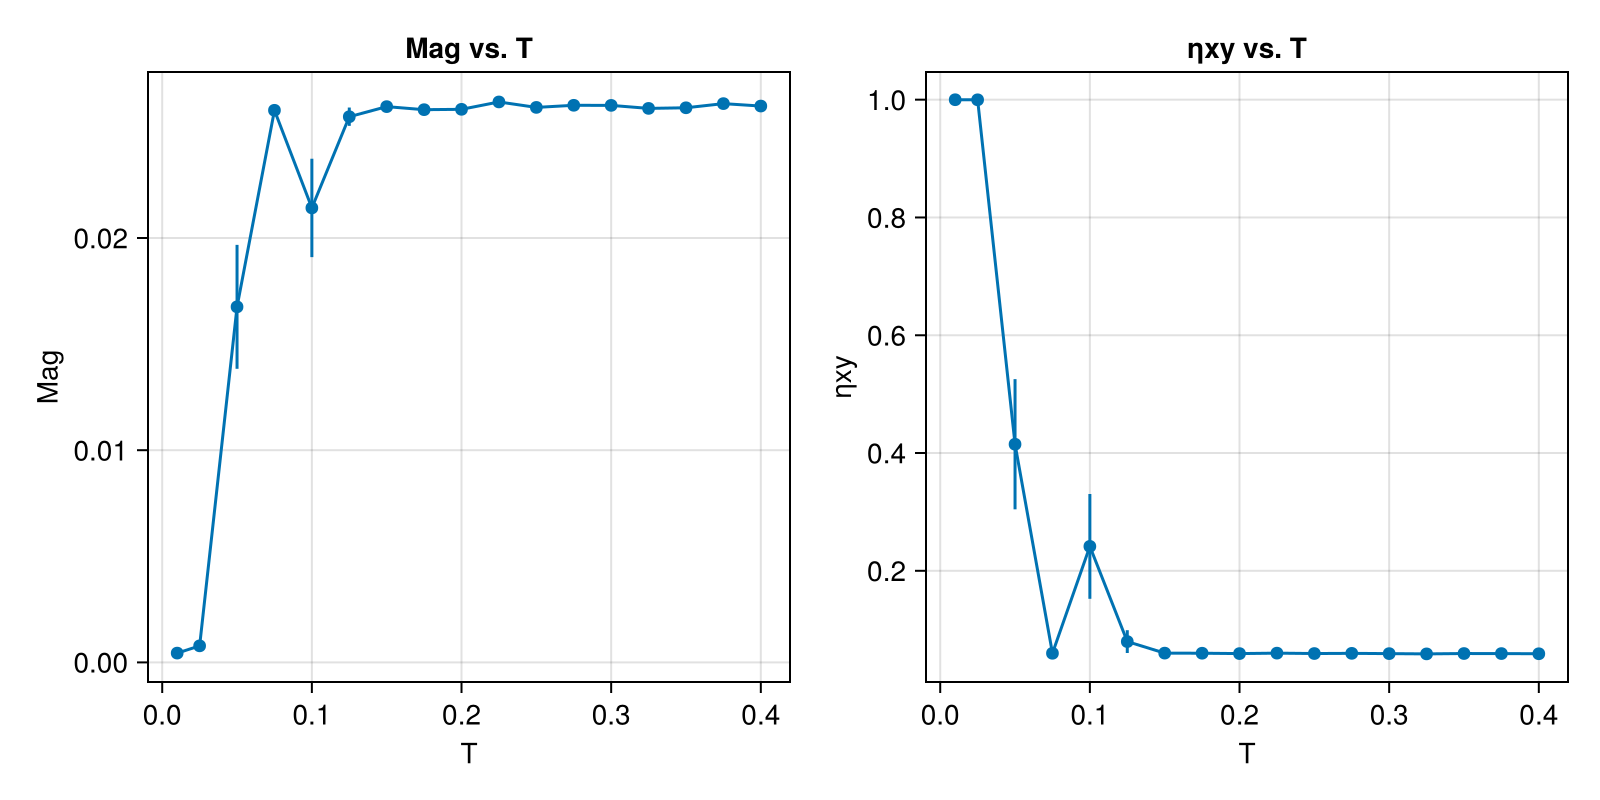

In [10]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, border_results; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, border_results; line=true)
fig

In [12]:
border_mctimes = get_mctime_data(border_results, :Mag, :ηxy)

17-element Vector{DataFrame}:
 400×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000271464  0.999896
   2 │ 0.000182794  0.999896
   3 │ 0.000197197  0.999896
   4 │ 0.000229268  0.999896
   5 │ 0.000293473  0.999896
   6 │ 0.000249069  0.999896
   7 │ 0.000243349  0.999896
   8 │ 0.000253358  0.999896
  ⋮  │      ⋮          ⋮
 394 │ 0.000330045  0.999902
 395 │ 0.000179694  0.999902
 396 │ 0.000252888  0.999903
 397 │ 0.000313207  0.999903
 398 │ 0.000338003  0.999904
 399 │ 0.000435715  0.999904
 400 │ 0.000489401  0.999904
             385 rows omitted
 400×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000390099  0.999771
   2 │ 0.000718606  0.999772
   3 │ 0.000845632  0.999772
   4 │ 0.000760826  0.999771
   5 │ 0.000983771  0.999771
   6 │ 0.000757555  0.999771
   7 │ 0.00055558   0.99977
   8 │ 0.000436167  0.99977
  ⋮  │      ⋮          ⋮
 394 │ 0.00

In [39]:
GLMakie.activate!()

fig = Figure()
fig[1,1] = ax = Axis(fig, title="ηxy vs. Bin #", xlabel="Bin #", ylabel="ηxy")
sg = SliderGrid(
    fig[2, 1],
    (label="Task #", range=1:17, format="{:.1f}", startvalue=1, update_while_dragging=false)
)
slider = sg.sliders[1]
mcdata = lift(slider.value) do i
    border_mctimes[i][:, :ηxy]
end
on(mcdata) do mcdata
    empty!(ax)
    lines!(ax, 1:400, mcdata)
    autolimits!(ax)
end
fig

## AFM-FE Phase Center

In [5]:
center_results = JobResult("../jobs", "afm-fe-center")

JobResult("../jobs", "afm-fe-center", 13×23 DataFrame
 Row │ ηz                T        etak_corrs                         _ll_sweep ⋯
     │ Measurem…         Float64  Array…                             Measurem… ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -7.6e-5±6.1e-5      0.01   Complex{Measurement{Float64}}[66…  0.0003866 ⋯
   2 │  0.0001±0.00011     0.025  Complex{Measurement{Float64}}[66…  0.0003749
   3 │  0.0003±0.00025     0.05   Complex{Measurement{Float64}}[66…  0.000401±
   4 │  8.7e-5±0.00024     0.075  Complex{Measurement{Float64}}[41…  0.0003983
   5 │  0.00041±0.00038    0.1    Complex{Measurement{Float64}}[63…  0.000422± ⋯
   6 │  0.00028±0.00022    0.125  Complex{Measurement{Float64}}[62…  0.0004051
   7 │ -0.00032±0.00034    0.15   Complex{Measurement{Float64}}[54…  0.0004056
   8 │ -0.00064±0.00035    0.175  Complex{Measurement{Float64}}[60…  0.0004016
   9 │ -0.00042±0.00025    0.2    Complex{Measurement{Float64}}[62…

In [6]:
center_results[[:_ll_sweep_time, :_ll_measure_time]]

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.0003866±6.9e-6,0.000192±4.1e-5
2,0.0003749±2.0e-6,0.0001421±7.4e-6
3,0.000401±1.5e-5,0.000166±1.7e-5
4,0.0003983±5.8e-6,0.000162±1.5e-5
5,0.000422±6.7e-6,0.000171±1.1e-5
6,0.0004051±2.6e-6,0.0001499±5.5e-6
7,0.0004056±3.5e-6,0.0001437±6.3e-6
8,0.0004016±2.0e-6,0.0001407±4.5e-6
9,0.0004002±1.2e-6,0.0001368±5.1e-6


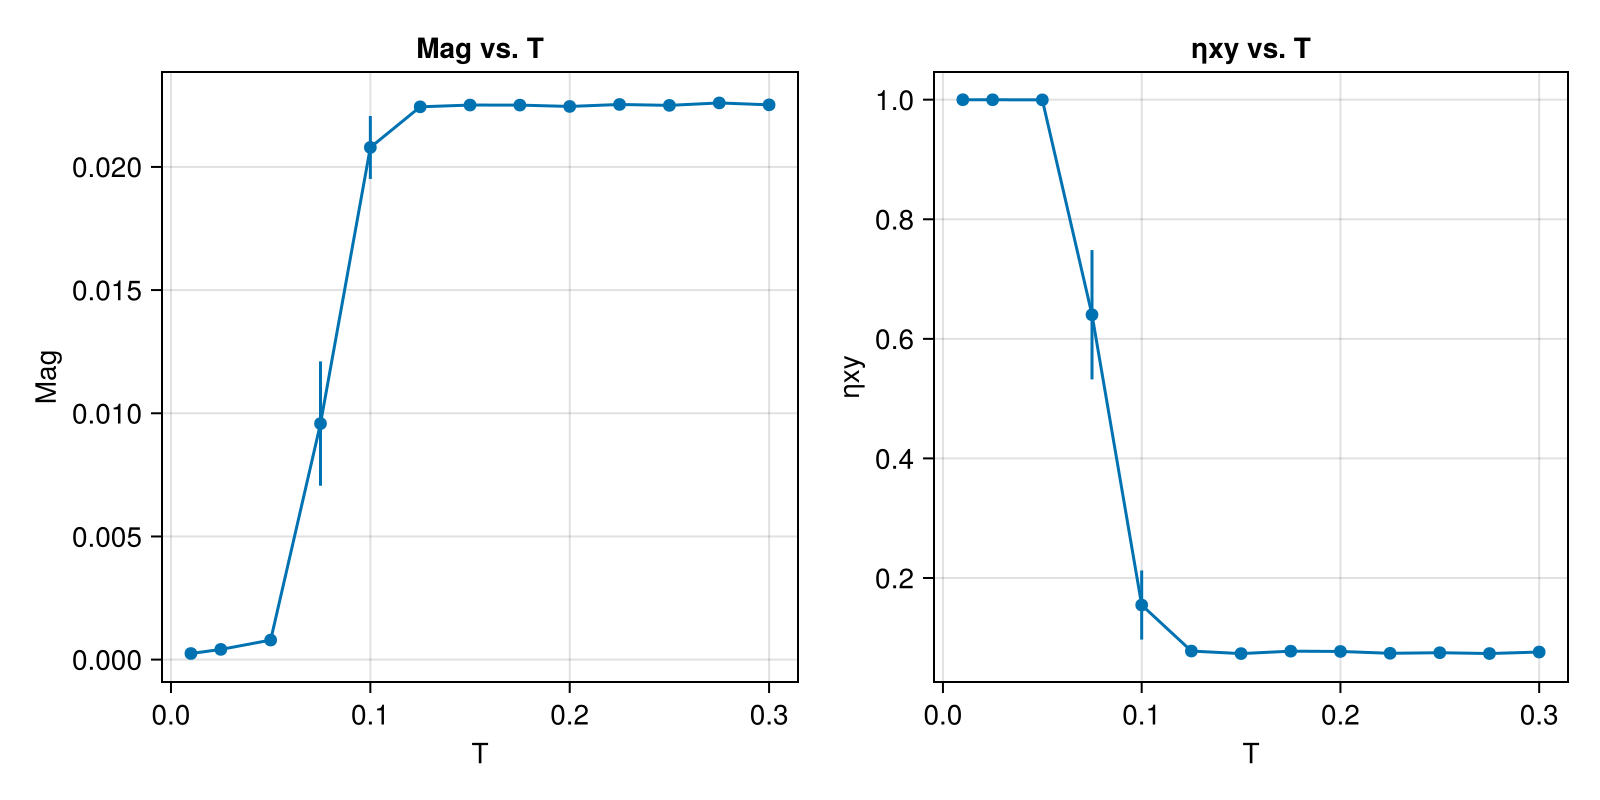

In [7]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, center_results; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, center_results; line=true)
fig

In [8]:
center_mctimes = get_mctime_data(center_results, :Mag, :ηxy)

13-element Vector{DataFrame}:
 400×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000101422  0.999936
   2 │ 0.000103075  0.999936
   3 │ 0.000102785  0.999936
   4 │ 6.90139e-5   0.999936
   5 │ 5.67692e-5   0.999936
   6 │ 5.84821e-5   0.999936
   7 │ 5.33401e-5   0.999936
   8 │ 6.21405e-5   0.999936
  ⋮  │      ⋮          ⋮
 394 │ 0.000893966  0.999947
 395 │ 0.00093305   0.999947
 396 │ 0.000880599  0.999946
 397 │ 0.000829703  0.999947
 398 │ 0.000832234  0.999947
 399 │ 0.000789935  0.999946
 400 │ 0.000834024  0.999947
             385 rows omitted
 400×2 DataFrame
 Row │ Mag          ηxy      
     │ Float64      Float64  
─────┼───────────────────────
   1 │ 0.000278329  0.999876
   2 │ 0.000291858  0.999876
   3 │ 0.000323262  0.999876
   4 │ 0.00037634   0.999878
   5 │ 0.000480742  0.999877
   6 │ 0.000571824  0.999877
   7 │ 0.000488634  0.999877
   8 │ 0.000621363  0.999875
  ⋮  │      ⋮          ⋮
 394 │ 0.

In [9]:
GLMakie.activate!()

fig = Figure()
fig[1,1] = ax = Axis(fig, title="ηxy vs. Bin #", xlabel="Bin #", ylabel="ηxy")
sg = SliderGrid(
    fig[2, 1],
    (label="Task #", range=1:17, format="{:.1f}", startvalue=1, update_while_dragging=false)
)
slider = sg.sliders[1]
mcdata = lift(slider.value) do i
    center_mctimes[i][:, :ηxy]
end
on(mcdata) do mcdata
    empty!(ax)
    lines!(ax, 1:400, mcdata)
    autolimits!(ax)
end
fig

In [10]:
spink_corrs = center_results[:spink_corrs] ./ 400^2

13-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [8.7e-8 ± 2.6e-8 2.74e-7 ± 4.6e-8 … 2.28e-7 ± 3.3e-8 2.74e-7 ± 4.6e-8; 1.29e-7 ± 2.3e-8 1.46e-7 ± 1.1e-8 … 2.57e-7 ± 3.3e-8 1.77e-7 ± 2.7e-8; … ; 1.8e-7 ± 2.3e-8 1.5e-7 ± 2.0e-8 … 1.69e-7 ± 2.9e-8 1.82e-7 ± 1.8e-8; 1.29e-7 ± 2.3e-8 1.77e-7 ± 2.7e-8 … 1.37e-7 ± 1.1e-8 1.46e-7 ± 1.1e-8]
 [2.11e-7 ± 3.8e-8 4.44e-7 ± 5.7e-8 … 4.13e-7 ± 6.6e-8 4.44e-7 ± 5.7e-8; 3.91e-7 ± 5.4e-8 3.17e-7 ± 3.0e-8 … 4.14e-7 ± 5.3e-8 4.44e-7 ± 6.9e-8; … ; 4.86e-7 ± 6.9e-8 3.84e-7 ± 4.6e-8 … 3.43e-7 ± 5.2e-8 3.36e-7 ± 3.0e-8; 3.91e-7 ± 5.4e-8 4.44e-7 ± 6.9e-8 … 3.76e-7 ± 4.3e-8 3.17e-7 ± 3.0e-8]
 [7.74e-7 ± 9.0e-8 8.1e-7 ± 1.2e-7 … 7.89e-7 ± 8.6e-8 8.1e-7 ± 1.2e-7; 8.79e-7 ± 8.4e-8 7.31e-7 ± 7.7e-8 … 8.8e-7 ± 1.1e-7 7.9e-7 ± 1.2e-7; … ; 8.49e-7 ± 9.7e-8 9.01e-7 ± 1.0e-7 … 7.16e-7 ± 8.6e-8 7.59e-7 ± 6.3e-8; 8.79e-7 ± 8.4e-8 7.9e-7 ± 1.2e-7 … 8.18e-7 ± 8.4e-8 7.31e-7 ± 7.7e-8]
 [0.000232 ± 7.0e-5 0.000235 ± 7.1e-5 … 0.000253 ± 7.6e-5 0.000235 ± 7.1e-5;

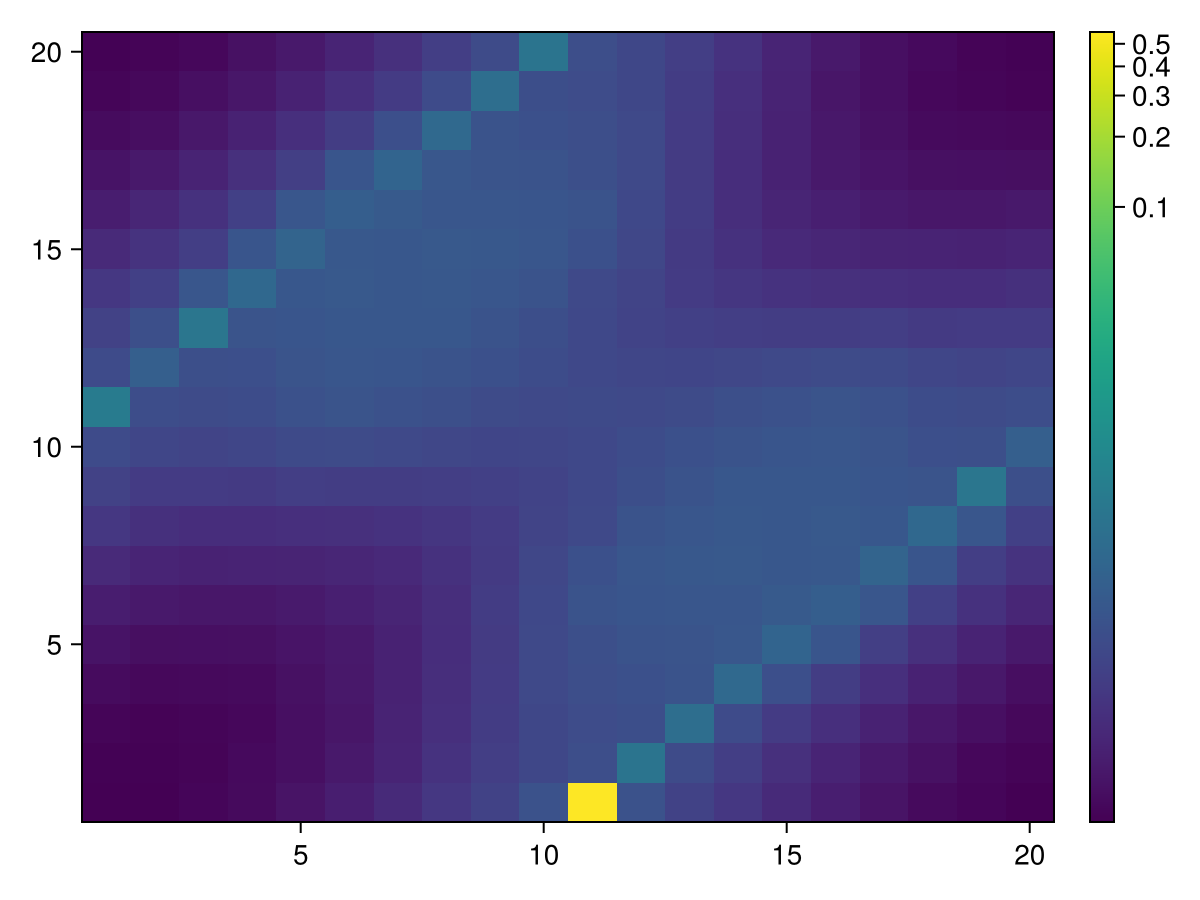

In [18]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[4], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

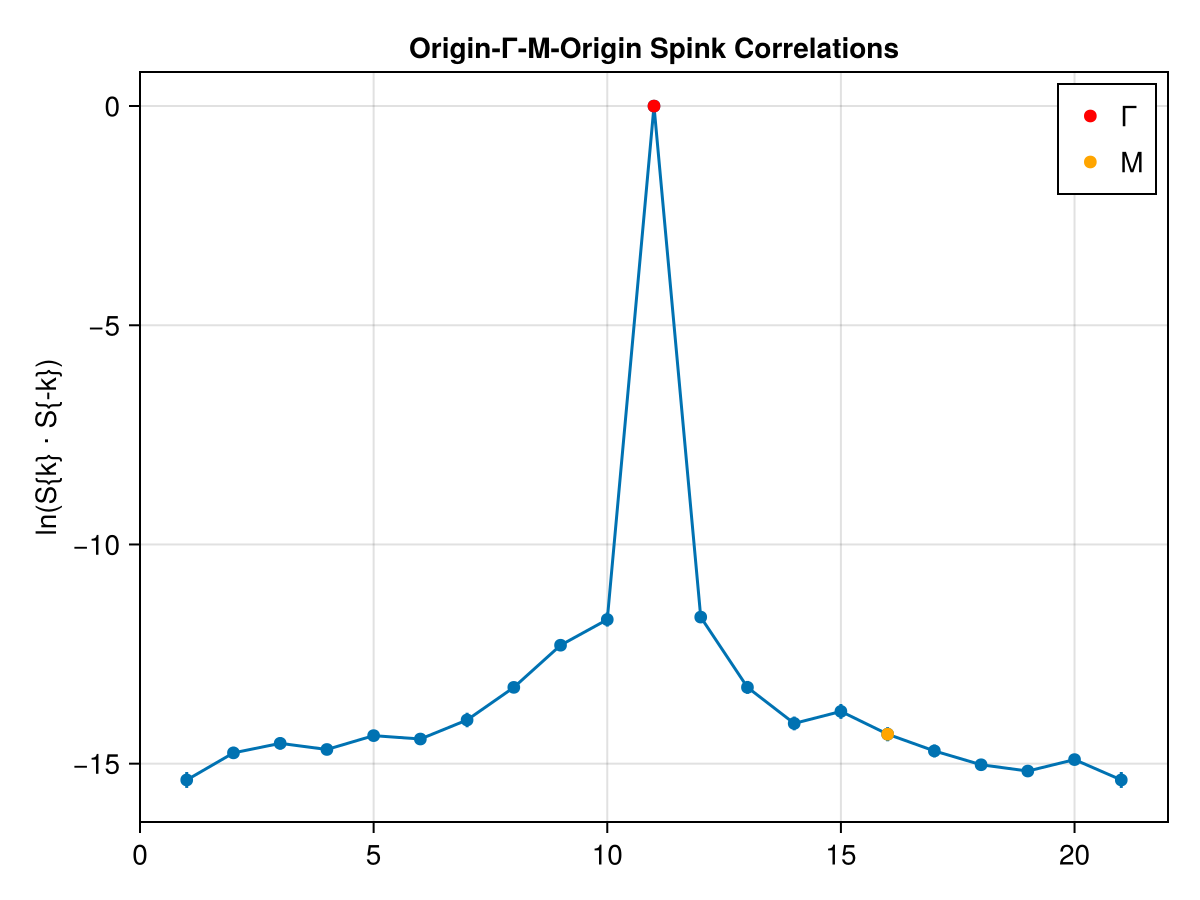

In [22]:
CairoMakie.activate!()
taskno = 2
Lx, Ly = size(spink_corrs[taskno])
borderx = div(Lx, 2) + 1
bordery = div(Ly, 2) + 1

Γ_path = [(i, 1) for i in 1:borderx]
M_path = [(borderx, i) for i in 2:(div(bordery, 2) + 1)]
O_path = [(borderx - 2i, div(bordery, 2) - i + 1) for i in 1:div(borderx, 2)]
path = cat(Γ_path, M_path, O_path, dims=1)

Γ_pos = length(Γ_path)
M_pos = length(Γ_path) + length(M_path)
corrs = [spink_corrs[taskno][I...] for I in path]

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Origin-Γ-M-Origin Spink Correlations",
    ylabel="ln(S{k} ⋅ S{-k})"
)
log_corrs = log.(corrs)
scatter!(ax, log_corrs)
errorbars!(ax, 1:length(path), getfield.(log_corrs, :val), getfield.(log_corrs, :err))
lines!(ax, log_corrs)
scatter!(ax, Γ_pos, log(corrs[Γ_pos].val), color=:red, label="Γ")
scatter!(ax, M_pos, log(corrs[M_pos].val), color=:orange, label="M")
axislegend()
fig

In [13]:
to_triangle((x, y)) = ((x-1), (-(x-1) + 2(y-1)) / sqrt(3)) ./ 20
positions = to_triangle.(Iterators.product(axes(getfield.(spink_corrs[1], :val))...))

20×20 Matrix{Tuple{Float64, Float64}}:
 (0.0, 0.0)          …  (0.0, 1.03923)    (0.0, 1.09697)
 (0.05, -0.0288675)     (0.05, 1.01036)   (0.05, 1.0681)
 (0.1, -0.057735)       (0.1, 0.981495)   (0.1, 1.03923)
 (0.15, -0.0866025)     (0.15, 0.952628)  (0.15, 1.01036)
 (0.2, -0.11547)        (0.2, 0.92376)    (0.2, 0.981495)
 (0.25, -0.144338)   …  (0.25, 0.894893)  (0.25, 0.952628)
 (0.3, -0.173205)       (0.3, 0.866025)   (0.3, 0.92376)
 (0.35, -0.202073)      (0.35, 0.837158)  (0.35, 0.894893)
 (0.4, -0.23094)        (0.4, 0.80829)    (0.4, 0.866025)
 (0.45, -0.259808)      (0.45, 0.779423)  (0.45, 0.837158)
 (0.5, -0.288675)    …  (0.5, 0.750555)   (0.5, 0.80829)
 (0.55, -0.317543)      (0.55, 0.721688)  (0.55, 0.779423)
 (0.6, -0.34641)        (0.6, 0.69282)    (0.6, 0.750555)
 (0.65, -0.375278)      (0.65, 0.663953)  (0.65, 0.721688)
 (0.7, -0.404145)       (0.7, 0.635085)   (0.7, 0.69282)
 (0.75, -0.433013)   …  (0.75, 0.606218)  (0.75, 0.663953)
 (0.8, -0.46188)        (0.8, 0.5

In [14]:
GLMakie.activate!()
xs = 10 .* getindex.(positions, 1)
ys = 10 .* getindex.(positions, 2)
# surface(xs, ys, log.(getfield.(spink_corrs[2], :val)))

20×20 Matrix{Float64}:
  0.0        0.57735    1.1547     1.73205   …  9.81495  10.3923   10.9697
 -0.288675   0.288675   0.866025   1.44338      9.52628  10.1036   10.681
 -0.57735    0.0        0.57735    1.1547       9.2376    9.81495  10.3923
 -0.866025  -0.288675   0.288675   0.866025     8.94893   9.52628  10.1036
 -1.1547    -0.57735    0.0        0.57735      8.66025   9.2376    9.81495
 -1.44338   -0.866025  -0.288675   0.288675  …  8.37158   8.94893   9.52628
 -1.73205   -1.1547    -0.57735    0.0          8.0829    8.66025   9.2376
 -2.02073   -1.44338   -0.866025  -0.288675     7.79423   8.37158   8.94893
 -2.3094    -1.73205   -1.1547    -0.57735      7.50555   8.0829    8.66025
 -2.59808   -2.02073   -1.44338   -0.866025     7.21688   7.79423   8.37158
 -2.88675   -2.3094    -1.73205   -1.1547    …  6.9282    7.50555   8.0829
 -3.17543   -2.59808   -2.02073   -1.44338      6.63953   7.21688   7.79423
 -3.4641    -2.88675   -2.3094    -1.73205      6.35085   6.9282    7.50

## Phase Center Annealed

In [20]:
center_results = JobResult("../jobs", "afm-fe-anneal")

JobResult("../jobs", "afm-fe-anneal", 13×23 DataFrame
 Row │ ηz                T        init_T  etak_corrs                         _ ⋯
     │ Measurem…         Float64  Int64   Array…                             M ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.00039±0.00022    0.01       10  Complex{Measurement{Float64}}[62…  0 ⋯
   2 │ -0.0002±0.00024     0.025      10  Complex{Measurement{Float64}}[63…  0
   3 │ -0.00016±0.00025    0.05       10  Complex{Measurement{Float64}}[54…  0
   4 │  0.0001±0.00027     0.075      10  Complex{Measurement{Float64}}[62…  0
   5 │  0.00036±0.00031    0.1        10  Complex{Measurement{Float64}}[56…  0 ⋯
   6 │  0.00032±0.00027    0.125      10  Complex{Measurement{Float64}}[60…  0
   7 │  4.5e-5±0.00032     0.15       10  Complex{Measurement{Float64}}[58…  0
   8 │  0.00021±0.00023    0.175      10  Complex{Measurement{Float64}}[57…  0
   9 │ -0.00027±0.0003     0.2        10  Complex{Measurement{Float

In [21]:
center_results[[:_ll_sweep_time, :_ll_measure_time]]

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.000421±1.9e-5,0.000216±2.3e-5
2,0.0003885±2.3e-6,0.000182±1.8e-5
3,0.0004033±5.8e-6,0.0001634±9.6e-6
4,0.000453±1.5e-5,0.000227±2.6e-5
5,0.000437±1.4e-5,0.000179±1.2e-5
6,0.000596±4.1e-5,0.000349±3.9e-5
7,0.00044±1.4e-5,0.000179±1.4e-5
8,0.000513±2.8e-5,0.000243±2.0e-5
9,0.000438±1.1e-5,0.000202±2.3e-5


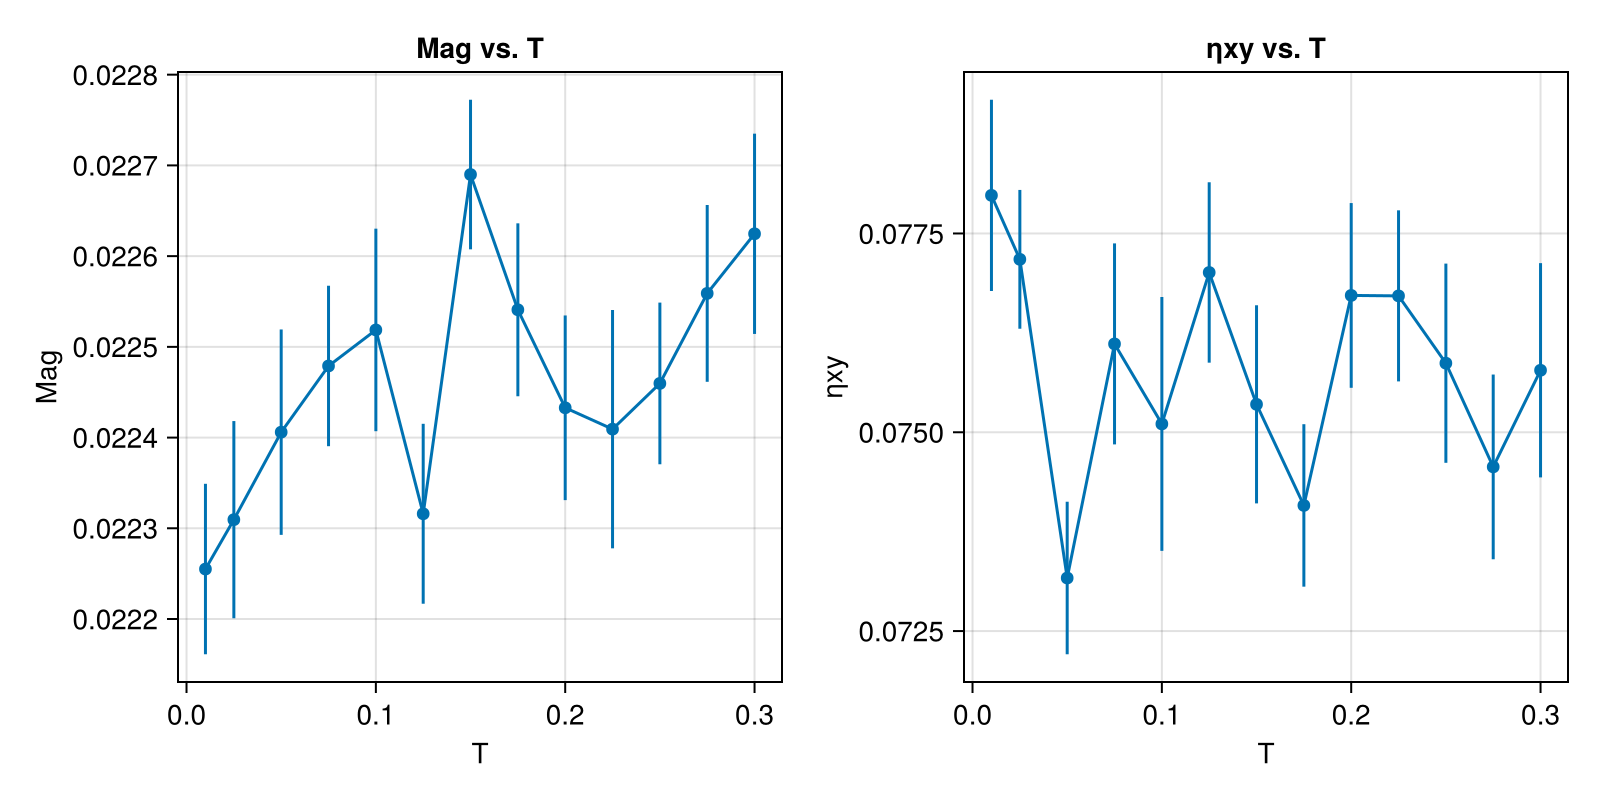

In [22]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, center_results; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηxy vs. T", xlabel="T", ylabel="ηxy")
generate_plot!(ax_η, :T, :ηxy, center_results; line=true)
fig

In [23]:
center_mctimes = get_mctime_data(center_results, :Mag, :ηxy)

13-element Vector{DataFrame}:
 500×2 DataFrame
 Row │ Mag        ηxy       
     │ Float64    Float64   
─────┼──────────────────────
   1 │ 0.021114   0.0757172
   2 │ 0.0250149  0.0456236
   3 │ 0.0216451  0.0685094
   4 │ 0.0219355  0.0745958
   5 │ 0.019767   0.0725102
   6 │ 0.0224885  0.0843629
   7 │ 0.0214541  0.104515
   8 │ 0.0209258  0.0647021
  ⋮  │     ⋮          ⋮
 494 │ 0.0245306  0.126486
 495 │ 0.0254841  0.0912421
 496 │ 0.0207905  0.0846739
 497 │ 0.022125   0.100476
 498 │ 0.0269356  0.0804895
 499 │ 0.0233005  0.0658388
 500 │ 0.0260671  0.0775518
            485 rows omitted
 500×2 DataFrame
 Row │ Mag        ηxy       
     │ Float64    Float64   
─────┼──────────────────────
   1 │ 0.0210167  0.0608238
   2 │ 0.022584   0.076073
   3 │ 0.0217716  0.054269
   4 │ 0.0188209  0.0345229
   5 │ 0.0221986  0.0486046
   6 │ 0.0220733  0.0690237
   7 │ 0.0207575  0.0555685
   8 │ 0.0225217  0.0291963
  ⋮  │     ⋮          ⋮
 494 │ 0.0238433  0.0849717
 495 │ 0.0239594  

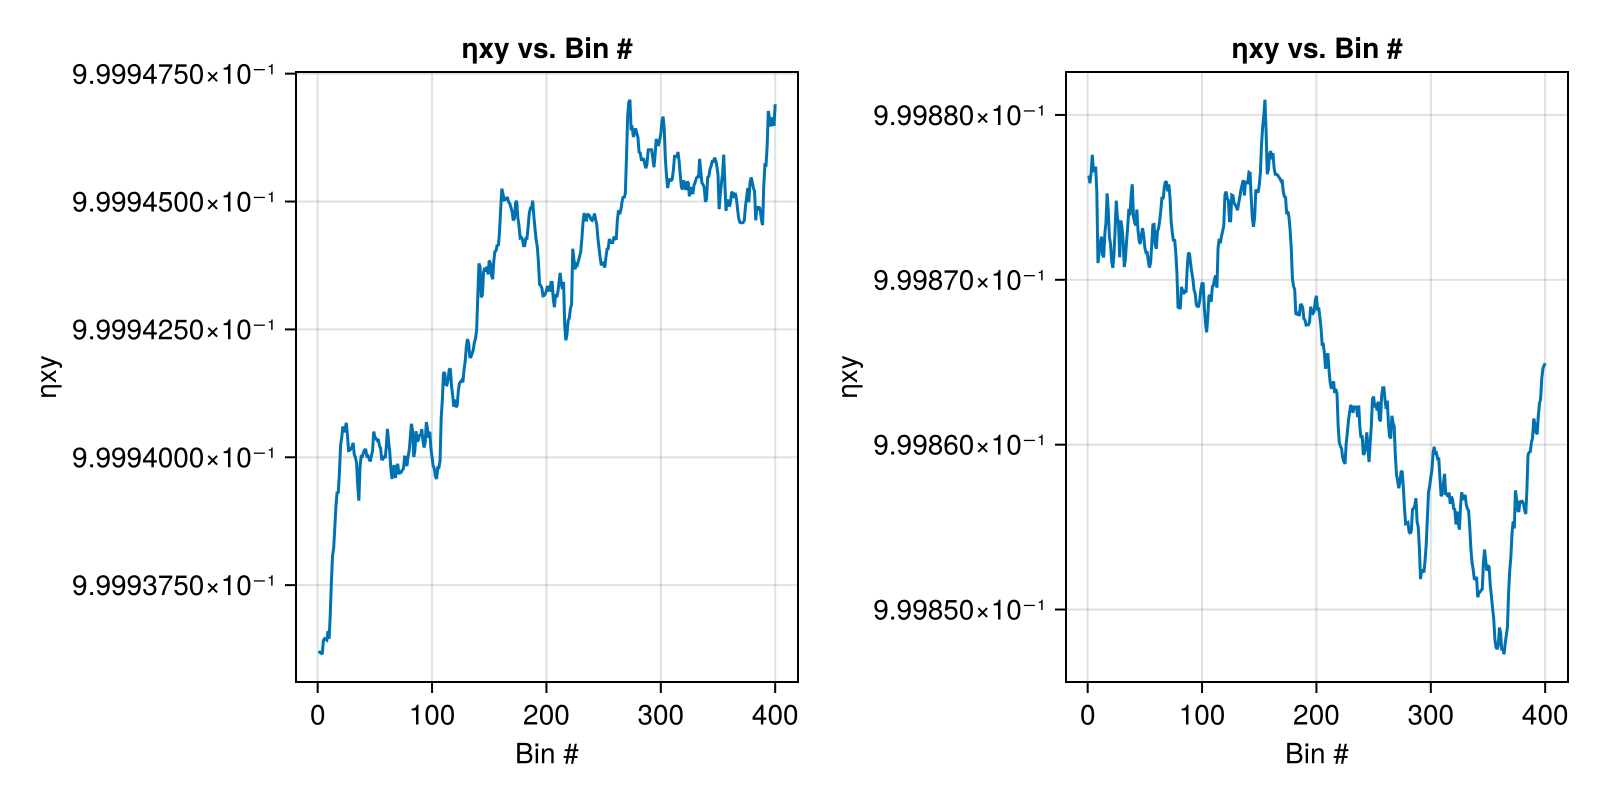

In [26]:
CairoMakie.activate!()
i = 1

fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="ηxy vs. Bin #", xlabel="Bin #", ylabel="ηxy")
fig[1,2] = ax2 = Axis(fig, title="ηxy vs. Bin #", xlabel="Bin #", ylabel="ηxy")
lines!(ax1, center_mctimes[i][:, :ηxy])
lines!(ax2, center_mctimes[i+1][:, :ηxy])
fig

In [25]:
spink_corrs = center_results[:spink_corrs] ./ 400^2

13-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [0.0005836 ± 4.7e-6 0.0006062 ± 3.6e-6 … 0.0006562 ± 4.7e-6 0.0006062 ± 3.6e-6; 0.0006013 ± 4.3e-6 0.0006069 ± 3.5e-6 … 0.0006972 ± 4.0e-6 0.0006304 ± 4.1e-6; … ; 0.000654 ± 3.4e-6 0.0006964 ± 4.3e-6 … 0.0006474 ± 3.3e-6 0.000635 ± 4.1e-6; 0.0006013 ± 4.3e-6 0.0006304 ± 4.1e-6 … 0.0006323 ± 3.1e-6 0.0006069 ± 3.5e-6]
 [0.0005867 ± 5.6e-6 0.000597 ± 3.5e-6 … 0.0006532 ± 3.2e-6 0.000597 ± 3.5e-6; 0.0006089 ± 3.1e-6 0.0006069 ± 3.3e-6 … 0.0007036 ± 4.9e-6 0.0006343 ± 4.8e-6; … ; 0.0006532 ± 4.2e-6 0.0007003 ± 4.4e-6 … 0.000644 ± 3.4e-6 0.0006313 ± 3.8e-6; 0.0006089 ± 3.1e-6 0.0006343 ± 4.8e-6 … 0.0006273 ± 4.5e-6 0.0006069 ± 3.3e-6]
 [0.0005927 ± 6.0e-6 0.000607 ± 4.0e-6 … 0.0006489 ± 3.6e-6 0.000607 ± 4.0e-6; 0.0006017 ± 3.1e-6 0.0006023 ± 3.6e-6 … 0.0006943 ± 4.0e-6 0.0006306 ± 3.9e-6; … ; 0.000647 ± 4.3e-6 0.0006954 ± 2.8e-6 … 0.0006527 ± 2.9e-6 0.0006349 ± 3.4e-6; 0.0006017 ± 3.1e-6 0.0006306 ± 3.9e-6 … 0.0006323 ± 3.6e-6 

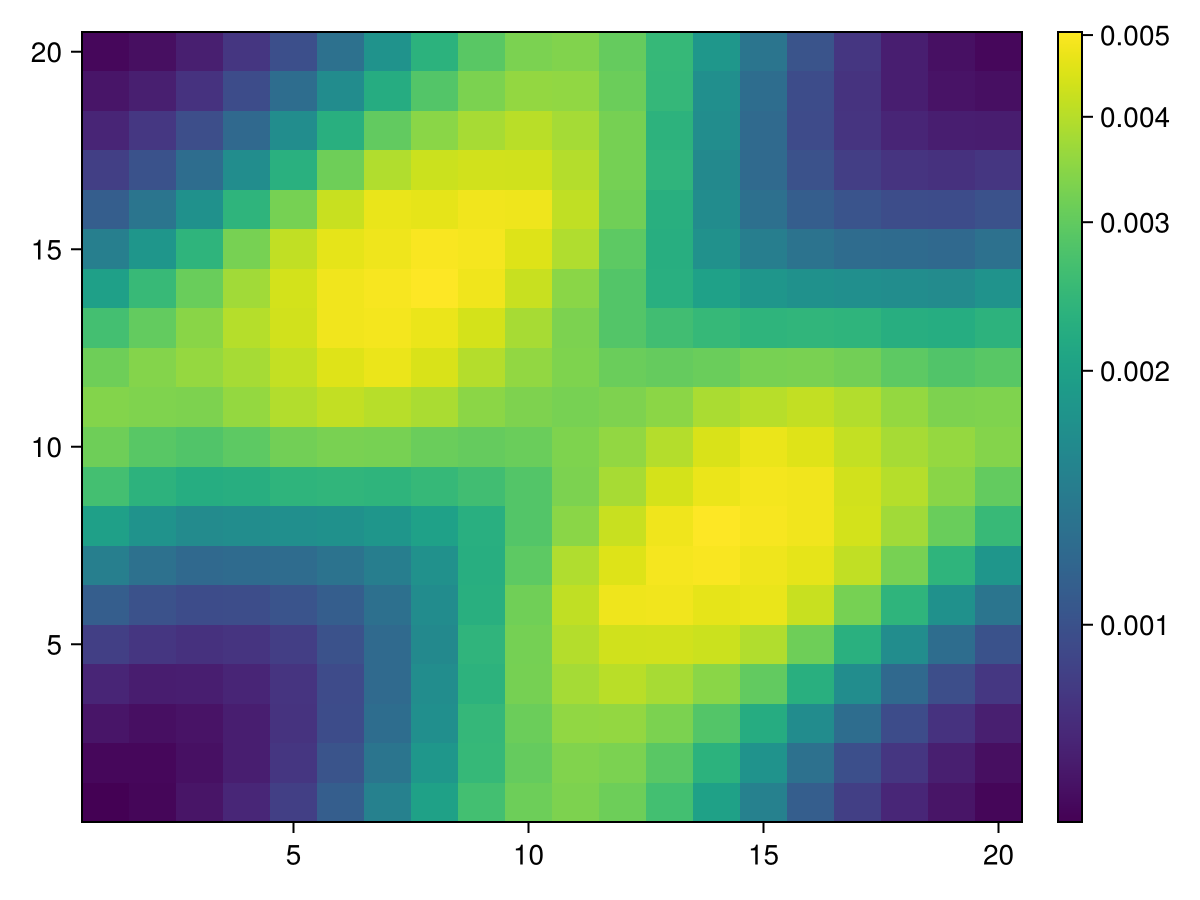

In [26]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[1], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

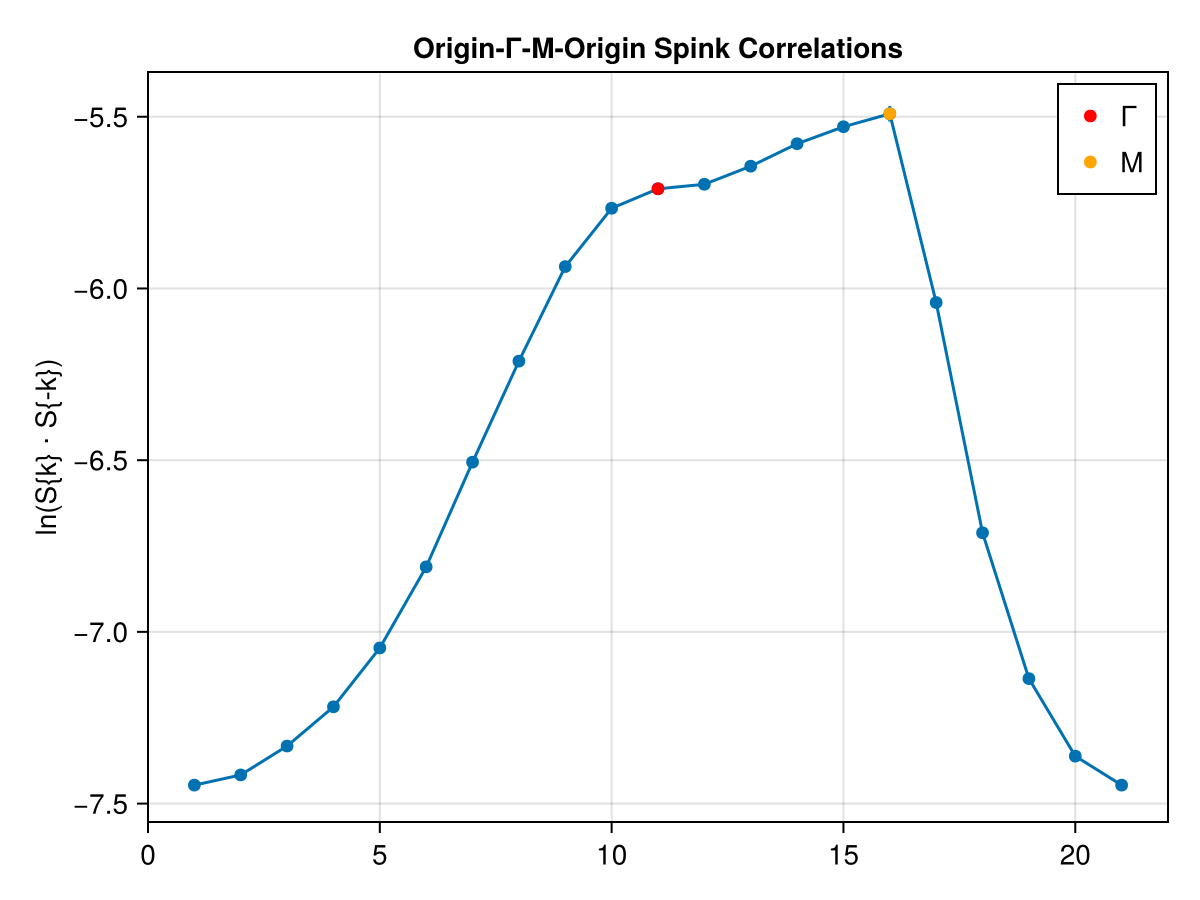

In [27]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])
borderx = div(Lx, 2) + 1
bordery = div(Ly, 2) + 1

Γ_path = [(i, 1) for i in 1:borderx]
M_path = [(borderx, i) for i in 2:(div(bordery, 2) + 1)]
O_path = [(borderx - 2i, div(bordery, 2) - i + 1) for i in 1:div(borderx, 2)]
path = cat(Γ_path, M_path, O_path, dims=1)

Γ_pos = length(Γ_path)
M_pos = length(Γ_path) + length(M_path)
corrs = [spink_corrs[1][I...] for I in path]

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Origin-Γ-M-Origin Spink Correlations",
    ylabel="ln(S{k} ⋅ S{-k})"
)
log_corrs = log.(corrs)
scatter!(ax, log_corrs)
errorbars!(ax, 1:length(path), getfield.(log_corrs, :val), getfield.(log_corrs, :err))
lines!(ax, log_corrs)
scatter!(ax, Γ_pos, log(corrs[Γ_pos].val), color=:red, label="Γ")
scatter!(ax, M_pos, log(corrs[M_pos].val), color=:orange, label="M")
axislegend()
fig

In [28]:
to_triangle((x, y)) = ((x-1), (-(x-1) + 2(y-1)) / sqrt(3)) ./ 20
positions = to_triangle.(Iterators.product(axes(getfield.(spink_corrs[1], :val))...))

20×20 Matrix{Tuple{Float64, Float64}}:
 (0.0, 0.0)          …  (0.0, 1.03923)    (0.0, 1.09697)
 (0.05, -0.0288675)     (0.05, 1.01036)   (0.05, 1.0681)
 (0.1, -0.057735)       (0.1, 0.981495)   (0.1, 1.03923)
 (0.15, -0.0866025)     (0.15, 0.952628)  (0.15, 1.01036)
 (0.2, -0.11547)        (0.2, 0.92376)    (0.2, 0.981495)
 (0.25, -0.144338)   …  (0.25, 0.894893)  (0.25, 0.952628)
 (0.3, -0.173205)       (0.3, 0.866025)   (0.3, 0.92376)
 (0.35, -0.202073)      (0.35, 0.837158)  (0.35, 0.894893)
 (0.4, -0.23094)        (0.4, 0.80829)    (0.4, 0.866025)
 (0.45, -0.259808)      (0.45, 0.779423)  (0.45, 0.837158)
 (0.5, -0.288675)    …  (0.5, 0.750555)   (0.5, 0.80829)
 (0.55, -0.317543)      (0.55, 0.721688)  (0.55, 0.779423)
 (0.6, -0.34641)        (0.6, 0.69282)    (0.6, 0.750555)
 (0.65, -0.375278)      (0.65, 0.663953)  (0.65, 0.721688)
 (0.7, -0.404145)       (0.7, 0.635085)   (0.7, 0.69282)
 (0.75, -0.433013)   …  (0.75, 0.606218)  (0.75, 0.663953)
 (0.8, -0.46188)        (0.8, 0.5

In [29]:
GLMakie.activate!()
xs = 10 .* getindex.(positions, 1)
ys = 10 .* getindex.(positions, 2)
# surface(xs, ys, log.(getfield.(spink_corrs[2], :val)))

20×20 Matrix{Float64}:
  0.0        0.57735    1.1547     1.73205   …  9.81495  10.3923   10.9697
 -0.288675   0.288675   0.866025   1.44338      9.52628  10.1036   10.681
 -0.57735    0.0        0.57735    1.1547       9.2376    9.81495  10.3923
 -0.866025  -0.288675   0.288675   0.866025     8.94893   9.52628  10.1036
 -1.1547    -0.57735    0.0        0.57735      8.66025   9.2376    9.81495
 -1.44338   -0.866025  -0.288675   0.288675  …  8.37158   8.94893   9.52628
 -1.73205   -1.1547    -0.57735    0.0          8.0829    8.66025   9.2376
 -2.02073   -1.44338   -0.866025  -0.288675     7.79423   8.37158   8.94893
 -2.3094    -1.73205   -1.1547    -0.57735      7.50555   8.0829    8.66025
 -2.59808   -2.02073   -1.44338   -0.866025     7.21688   7.79423   8.37158
 -2.88675   -2.3094    -1.73205   -1.1547    …  6.9282    7.50555   8.0829
 -3.17543   -2.59808   -2.02073   -1.44338      6.63953   7.21688   7.79423
 -3.4641    -2.88675   -2.3094    -1.73205      6.35085   6.9282    7.50